In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import xarray as xr
logger = logging.getLogger(__name__)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})

[ruth-macbook.whoi.edu:21082] shmem: mmap: an error occurred while determining whether or not /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T//ompi.ruth-macbook.503/jf.0/1430388736/sm_segment.ruth-macbook.503.55420000.0 could be created.


Here the time dependendent IVP problem we're looking to iterate starts from the following
$$ \nabla\cdot\Big(\frac{1}{h}\nabla\frac{\partial \psi}{\partial t}\Big)+f\hat{\mathbf{k}}\cdot \nabla\psi\times\nabla\Big(\frac{1}{h}\Big) = \underbrace{-\frac{\kappa}{h}\nabla\cdot\Big(\frac{1}{h}\nabla\psi\Big)}_{\text{dissipation}}+\underbrace{w_{Ek}\exp(ift \omega_\textrm{force})}_{\text{forcing}}$$
which is the system considered previously with no assumed form to the temporal dependence (no ansatz) and the inclusion of both dissipation and ekman forcing as some frequency or range of frequencies $\omega_\textrm{force}$.

Now I've made one modification to this initial idea in that I have translated this to a fully real problem$^*$ and expressed the forcing as a cosine since,
$$e^{ix} = \cos(x) + i\sin(x)$$
so,
$$\Re\big\{ w_\text{ek}\exp(ift \omega_\textrm{force}) \big\} =w_\text{ek} \cos(f\omega_\text{force}t) $$

Also, in this formulation I am setting,
$$\zeta = \frac{1}{h}\nabla{\psi}$$
so the problem being implemented is 
$$ \frac{\partial \zeta}{\partial t}  + f\hat{\mathbf{k}}\cdot \nabla\psi\times\nabla\Big(\frac{1}{h}\Big) = -\frac{\kappa}{h}\nabla\cdot\Big(\frac{1}{h}\nabla\psi\Big)+w_\text{ek} \cos(f\omega_\text{force}t)$$


Finally, we'll need to include the following boundary conditions,
$$\psi(r=R_i)=0$$
$$\textrm{Dirichlet to Neumann at }r = R_o$$
or potentially simply (this is what I've done at this stage)
$$\psi(r=R_o)=0$$


and tau terms (second order).


**note: this implementation is incorrect in that I use vector notation but I'm actually in a Cartesian basis not a Polar basis, this is corrected in the Dirichlet to Neumann implementation.**

## high frequency

In [2]:
## parameters 
Ri          = 0.5
Ro          = 6
Nθ          = 64;
Nr          = 32;
ω_force     = -0.24 # see above
κ           = 1e-3
ek_mag      = 0.1
Hmin_island = 0.25;
coriolis    = 1 # we nondimensionalize by f
α           = np.log(Hmin_island)/(2*np.log(Ri)); ## = 1

Hmmm really need a factor of $2\pi$ somewhere but I'm not sure if it's actually is in the expression (e.g. should it be $w_\text{ek}\cos(\frac{1}{2\pi}\omega_\text{force}ft)$??) or if it's only needed when I work out the forcing period for determining the timestep. Would expect subinertial waves to have a period of at least a day, but I'm not sure if that helps me.

In [3]:
## time evolution
timestepper    = d3.RK222
forcing_freq   = ω_force * coriolis
forcing_period = np.abs(1/forcing_freq) * 2 * np.pi
max_timestep   = forcing_period/500 # timestep = max_timestep in this implementation
stop_sim_time  = int(forcing_period * 5) 

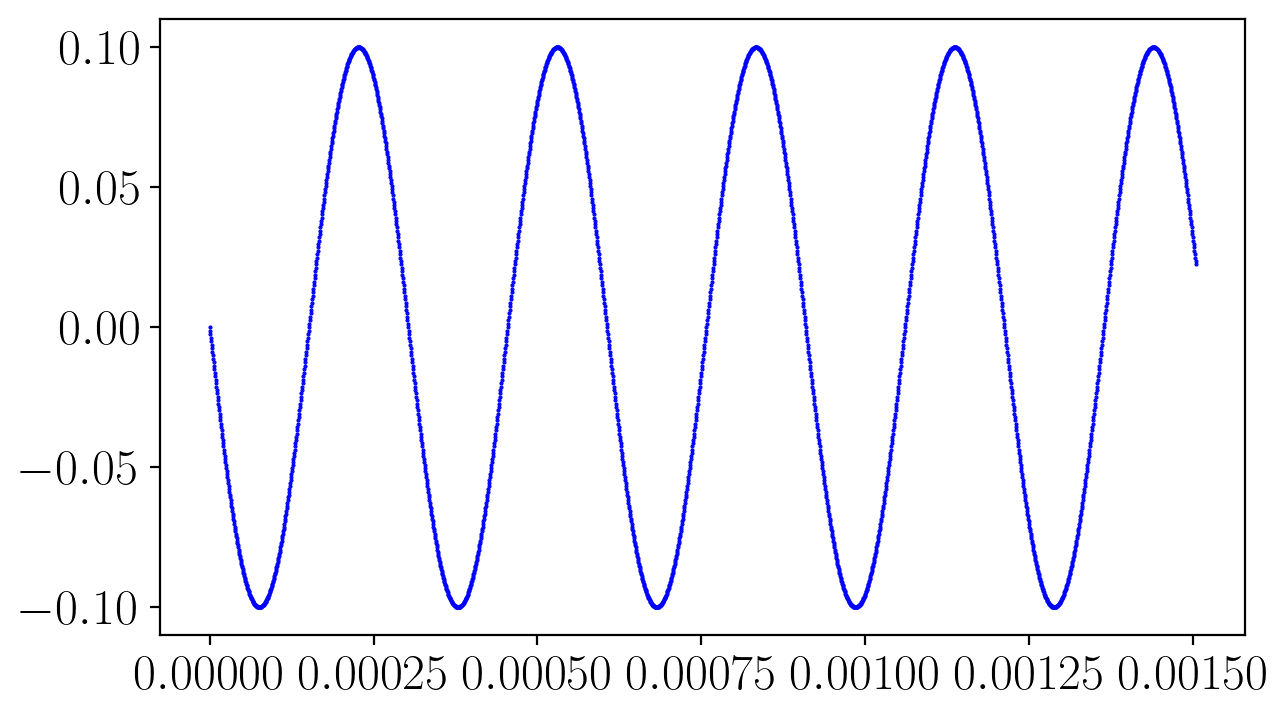

In [4]:
plot_forcing = ek_mag * np.sin(coriolis * ω_force * np.arange(0,stop_sim_time,max_timestep))
fig,(ax) = plt.subplots(1,1, figsize=(7,4))
ax.plot(np.arange(0,stop_sim_time,max_timestep)/(60*60*24),plot_forcing, 'bo', markersize=0.5)
plt.show()

In [5]:
## basis
dtype = np.float64
coords  = d3.CartesianCoordinates('θ', 'r')
dist    = d3.Distributor(coords, dtype=dtype)
θ_basis = d3.Fourier(coords['θ'], Nθ, (0, 2*np.pi), dtype=dtype)
r_basis = d3.Chebyshev(coords['r'], Nr, (Ri, Ro))

In [6]:
## fields
ψ    = dist.Field(name='ψ', bases=(θ_basis, r_basis))
tau1 = dist.Field(name='tau1', bases=θ_basis)
tau2 = dist.Field(name='tau2', bases=θ_basis)
t    = dist.Field(name='t')

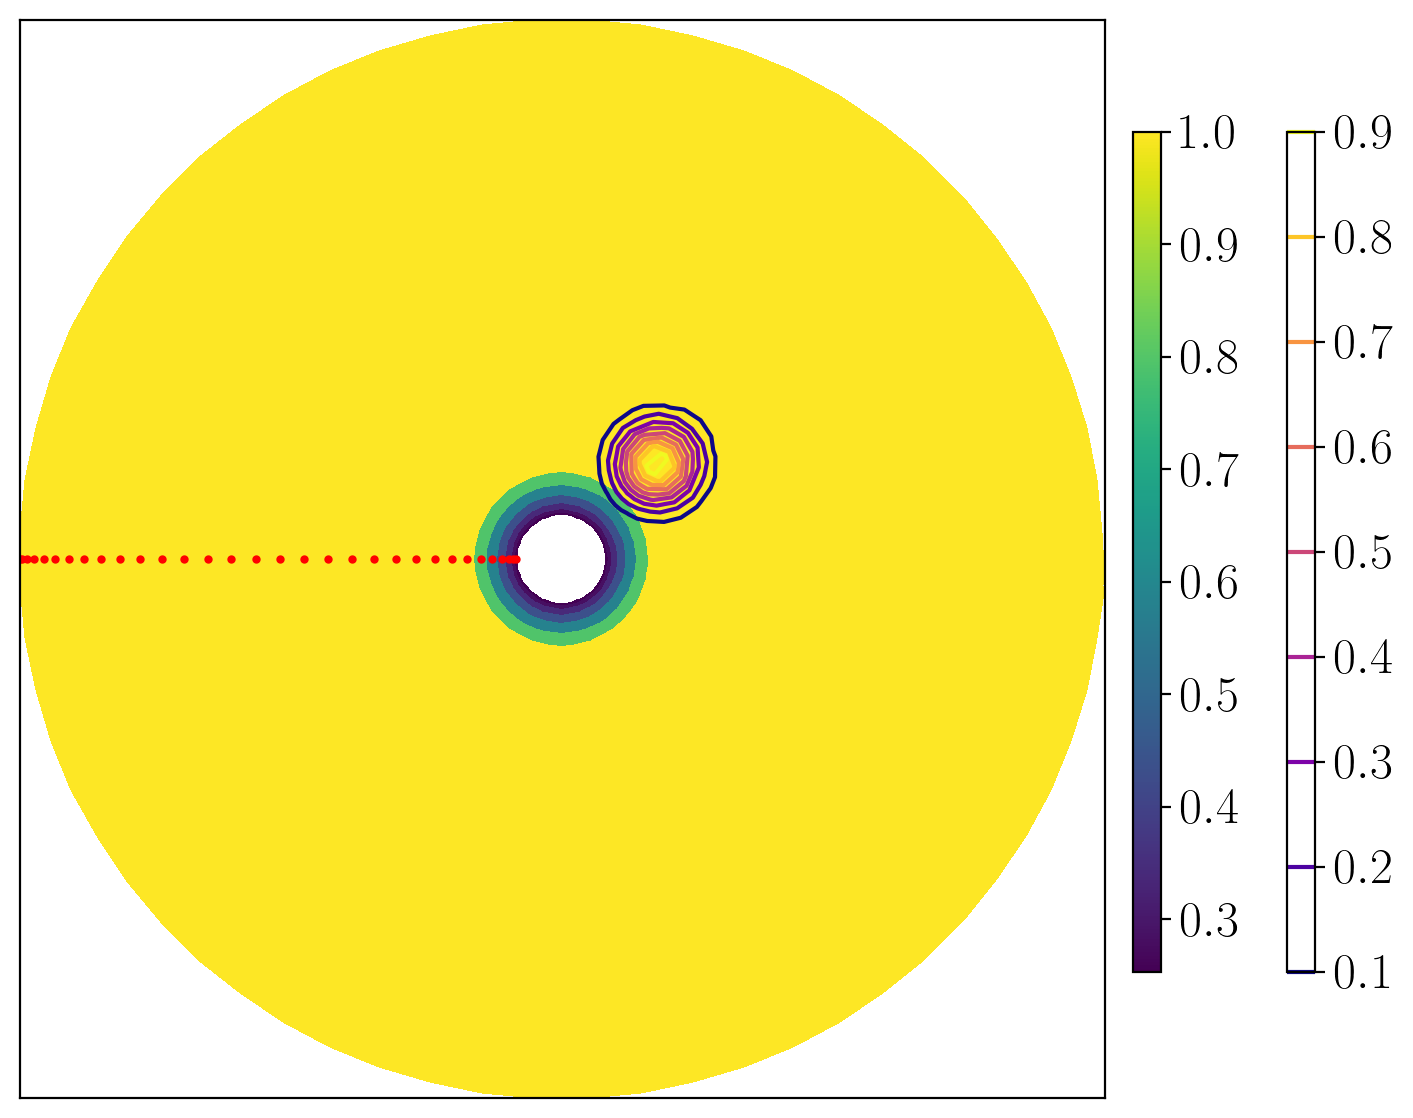

In [9]:
# Substitutions
θ, r = dist.local_grids(θ_basis, r_basis)
lift_basis = r_basis.derivative_basis(2)
tau_terms  = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)

# bathymetry (defined here as 1D not 2D)
hisland = r**(2*α) 
hisland[hisland>1] = 1
hinv = dist.Field(name='hinv',bases=(r_basis)) ## note that you run into problems if you give hinv a theta basis if it does not in actuality vary with theta
hinv['g'] = hisland**(-1)

R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

# define zeta
ζ = d3.div(hinv*d3.grad(ψ))

## forcing
r0 = 1.5; θ0 = np.pi/4; σ = 0.3;
gaussian = np.exp(-(x-r0*np.cos(θ0))**2/(2*σ**2) - (y-r0*np.sin(θ0))**2/(2*σ**2));

wek_spatial      = dist.Field(bases=(θ_basis, r_basis))
wek_spatial['g'] = ek_mag * gaussian 
wek              = wek_spatial * np.cos(ω_force * coriolis * t)

## plot fields ##
fig,(ax) = plt.subplots(1,1, figsize=(7,7))
c=ax.pcolormesh(x,y,(R*0+1)*(1/hinv['g'].real))
ax.plot(-r,0,'ro', markersize=2)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
f = ax.contour(x,y,gaussian, levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], cmap='plasma')
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.set_xticks([]);ax.set_yticks([])
cax = fig.add_axes([1.03, 0.2, 0.02, 0.6])
cbar=plt.colorbar(f,cax = cax,orientation='vertical',shrink = 0.5)
plt.show()

In [10]:
## problem
problem = d3.IVP([ψ, tau1, tau2], time=t, namespace=locals())
problem.add_equation("dt(ζ) - coriolis*(skew(grad(ψ))@grad(hinv)) +tau_terms = -κ*hinv*div(hinv*grad(ψ)) + wek")
problem.add_equation("ψ(r=Ri)=0") #inner BC
problem.add_equation("ψ(r=Ro)=0") #outer BC

{'LHS': interp(<Field 5338694096>, r=6),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': interp(<Field 5338694096>, r=6),
 'F': <Field 5340931920>,
 'domain': <dedalus.core.domain.Domain at 0x111d1ab10>,
 'matrix_dependence': array([False,  True]),
 'matrix_coupling': array([False,  True])}

In [11]:
## solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-08-02 15:14:59,559 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 1s, Remaining: 27s, Rate: 1.1e+00/s
2024-08-02 15:14:59,702 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 1s, Remaining: 7s, Rate: 3.9e+00/s
2024-08-02 15:14:59,889 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 1s, Remaining: 4s, Rate: 6.6e+00/s
2024-08-02 15:15:00,078 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 2s, Rate: 8.5e+00/s
2024-08-02 15:15:00,265 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 2s, Remaining: 2s, Rate: 1.0e+01/s
2024-08-02 15:15:00,451 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.1e+01/s
2024-08-02 15:15:00,637 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 2s, Remaining: 1s, Rate: 1.2e+01/s
2024-08-02 15:15:00,824 subsystems 0/1 INFO :: Building subproblem matri

In [12]:
# Analysis
snapshots = solver.evaluator.add_file_handler('dirichlet_snapshots', sim_dt=1)
snapshots.add_task(ψ, name='streamfunction')

In [13]:
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = max_timestep
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-08-02 15:15:17,399 __main__ 0/1 INFO :: Starting main loop
2024-08-02 15:15:17,543 __main__ 0/1 INFO :: Iteration=1, Time=5.235988e-02, dt=5.235988e-02
2024-08-02 15:15:17,604 __main__ 0/1 INFO :: Iteration=11, Time=5.759587e-01, dt=5.235988e-02
2024-08-02 15:15:17,670 __main__ 0/1 INFO :: Iteration=21, Time=1.099557e+00, dt=5.235988e-02
2024-08-02 15:15:17,729 __main__ 0/1 INFO :: Iteration=31, Time=1.623156e+00, dt=5.235988e-02
2024-08-02 15:15:17,792 __main__ 0/1 INFO :: Iteration=41, Time=2.146755e+00, dt=5.235988e-02
2024-08-02 15:15:17,851 __main__ 0/1 INFO :: Iteration=51, Time=2.670354e+00, dt=5.235988e-02
2024-08-02 15:15:17,915 __main__ 0/1 INFO :: Iteration=61, Time=3.193953e+00, dt=5.235988e-02
2024-08-02 15:15:17,974 __main__ 0/1 INFO :: Iteration=71, Time=3.717551e+00, dt=5.235988e-02
2024-08-02 15:15:18,036 __main__ 0/1 INFO :: Iteration=81, Time=4.241150e+00, dt=5.235988e-02
2024-08-02 15:15:18,099 __main__ 0/1 INFO :: Iteration=91, Time=4.764749e+00, dt=5.235988e-

In [15]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
import h5py

# Plot parameters
task = 'streamfunction'
cmap = plt.cm.RdBu_r
dpi = 100
figsize = (6, 6)

# Create figure
with h5py.File('dirichlet_snapshots/dirichlet_snapshots_s1.h5', mode='r') as file:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    # Plot writes
    dset = file['tasks'][task]
    theta = dset.dims[1][0][:]
    r = dset.dims[2][0][:]
    R,THETA = np.meshgrid(r,theta)
    x = R*np.cos(THETA); y=R*np.sin(THETA)
    data = np.real(dset[0])
    # clim = 0.04
    clim = np.max(np.abs(dset[:]))
    norm = matplotlib.colors.Normalize(-clim, clim)
    fc = cmap(norm(data))
    surf = ax.pcolormesh(x, y, data, cmap = cmap,clim = (-clim,clim))
    # ax.axis('off')

    def animate(i):
        data = dset[i]
        surf.set_array(np.real(data).ravel())
        return [surf]
    
    anim = animation.FuncAnimation(fig, animate, frames=dset.shape[0], interval=50, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video

2024-08-02 15:15:53,815 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-08-02 15:15:53,816 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 20.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/tmp58m91mhu/temp.m4v
